In [237]:

using Pkg
Pkg.activate(".")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using Gurobi

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/Project.toml`


In [238]:
innovations = CSV.File("./innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
innovations[2,6]=7
#innovations[2,3]=2
#innovations[2,2]=142

7

In [239]:
#using Pkg;
#Pkg.build("BARON")

In [264]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end

function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    #temp1=Diagonal(eigvals(q))
    #temp2=reshape(reduce(vcat,(I(5)+t.*temp1)),5,5)
    #d=eigvecs(q)'*(temp2)*inv(eigvecs(q)')
    #rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end


get_RL_atT (generic function with 1 method)

In [265]:
get_RL_atT(5,50)

3.614915662058677

In [242]:
function tech_roadmap()
    rdmap= Model(Gurobi.Optimizer)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    @variable(rdmap, 1 ≤ s[i=1:nrow(innovations)] )
    
    @variable(rdmap, co2_2050 ≥ 0)
    @variable(rdmap, co2_total ≥ 0)
    @variable(rdmap, cost_inn≥ 0)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1,k=1:mapki[i,2]], ti[i] ≤ tk[k])
    @constraint(rdmap, [i=2:nrow(mapki),k=mapki[i-1,2]:mapki[i,2]], ti[i] ≤ tk[k])
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3]*get_IAM_factor(tk[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #@constraint(rdmap, co2_total == calc_tot_co2(xk,tk))
    
    @constraint(rdmap, [i=1:nrow(innovations)], s[i]==get_RL_atT(i,ti[i]))
    
    @constraint(rdmap, co2_2050 ≤ 75)
    @constraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])) for i in 1:nrow(innovations)))
    @objective(rdmap,Min, cost_inn)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn)  
end

tech_roadmap (generic function with 1 method)

In [243]:
yk, tk, xk, yi, ti, s, co2, cost1=tech_roadmap()
yi

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-07


┌ Warning: Axis contains one element: 1. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[1]` instead of `1`.
└ @ JuMP.Containers /home/thakker.8/.julia/packages/JuMP/2IF9U/src/Containers/DenseAxisArray.jl:156


LoadError: MethodError: no method matching exp(::Matrix{AffExpr})
[0mClosest candidates are:
[0m  exp([91m::StridedMatrix{var"#s814"} where var"#s814"<:Union{Float32, Float64, ComplexF32, ComplexF64}[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/dense.jl:557
[0m  exp([91m::StridedMatrix{var"#s814"} where var"#s814"<:Union{Integer, Complex{var"#s813"} where var"#s813"<:Integer}[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/dense.jl:558
[0m  exp([91m::UniformScaling[39m) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:174
[0m  ...

In [180]:
ti

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 2.6645352591003757e-15

In [181]:
yi

5-element Vector{Float64}:
 -0.0
  1.0
 -0.0
 -0.0
 -0.0

In [182]:
co2

75.00000000000011

In [191]:
s

5-element Vector{Float64}:
 1.9999999999999998
 3.0
 1.0
 3.0
 1.0

In [184]:
cost1

244.0

In [185]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [13]:
get_RL_atT(4,50)

15.104427168668323

In [14]:
i=1
eDtmc=[[collect(innovations[i,9:13])],[collect(innovations[i,9:13])]]

2-element Vector{Vector{Vector{Real}}}:
 [[0, 0.76, 0.21, 0.03, 0]]
 [[0, 0.76, 0.21, 0.03, 0]]

In [15]:
innovations[1,9:13]

,P11,P12,P13,P14,P15
,Int64,Float64,Float64,Float64,Int64
1,0,0.76,0.21,0.03,0


In [16]:
collect(innovations[i,9:13])

5-element Vector{Real}:
 0
 0.76
 0.21
 0.03
 0

In [17]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.509675  0.259744  0.170531  0.0293273  0.0307228
 0.504729  0.25929   0.171824  0.0307344  0.0334224
 0.478735  0.253665  0.177902  0.0392907  0.050407
 0.392655  0.226214  0.190891  0.071864   0.118376
 0.337489  0.207874  0.198567  0.093104   0.162965

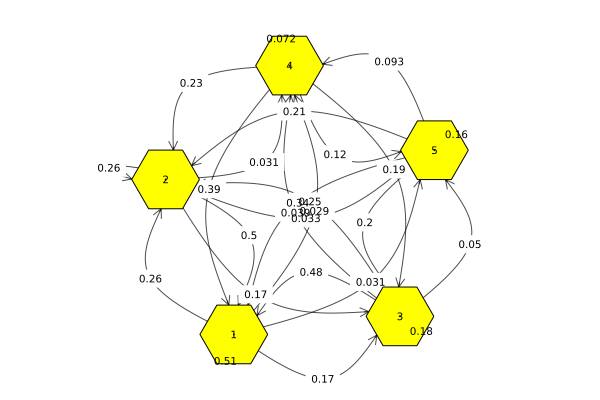

In [18]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)

In [19]:
tt=4
g+tt*g^2/2+tt^3*g^3/6+tt^4*g^4/24

5×5 Matrix{Float64}:
 11.9866  6.21598  4.23065  0.858264  1.0418
 11.9789  6.2147   4.23242  0.860706  1.04664
 11.9356  6.20397  4.24139  0.875612  1.07675
 11.7827  6.15669  4.26553  0.932795  1.19564
 11.6838  6.12539  4.28048  0.97012   1.27351

In [20]:
exp(g*tt)

5×5 Matrix{Float64}:
 27.4385  13.7009   9.31179  1.87787  2.26905
 26.4119  14.6971   9.31812  1.88601  2.28504
 26.2659  13.6622  10.3495   1.93567  2.38489
 25.7592  13.5042   9.42851  3.12575  2.78049
 25.4324  13.3994   9.47688  2.24979  4.03972

In [21]:
tk=vec([1 34 2 112 44])
xk=vec([0.1 0.32 0.2 0.11 0.4])

5-element Vector{Float64}:
 0.1
 0.32
 0.2
 0.11
 0.4

In [22]:
xk[give_sorted(tk)]
v=give_sorted(tk)
v
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp
,Int64,Int64,Int64,Float64,Float64,Float64
1,1,1,80,0.6,0.5,0.0
2,2,1,86,0.66,0.55,0.0
3,3,1,91,0.68,0.567,0.0
4,4,1,95,0.7,0.583,0.0
5,5,2,60,0.4,0.0,0.2
6,6,2,64,0.48,0.0,0.24
7,7,2,68,0.5,0.0,0.27
8,8,2,76,0.52,0.0,0.34
9,9,2,80,0.54,0.0,0.37


In [23]:
q=get_rate_mat(2)
t=50
s0=[0 0 0 1 0]
(s0*(exp(q*t)))

1×5 Matrix{Float64}:
 0.392655  0.226214  0.190891  0.071864  0.118376

In [24]:
for i in 1:size(tk)[1]
    print(sum(xk[v[j]] for j in 1:i))
    print("\n")
end

0.1
0.30000000000000004
0.6200000000000001
1.02
1.1300000000000001


In [25]:
size(tk)[1]

5

In [26]:
for i in 1:(size(tk)[1]-1)
    print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
    print("\n")
end

96.0
34.8
-162.32
-1954.3200000000002


In [27]:
apprx=I+get_rate_mat(4)*50

5×5 Matrix{Float64}:
 -3.2027     2.42126    1.78144     0.0        0.0
  6.87956   -9.21963    2.93413     0.405941   0.0
  1.78832    3.83202   -6.54113     1.92079    0.0
  0.456204   0.308399   9.49102   -18.1842     8.92857
  0.0        0.0        0.763473    7.57426   -7.33773

In [28]:
n1=[1 2 3 4 5].*[0 0 1 0 0]*apprx

1×5 Matrix{Float64}:
 5.36496  11.4961  -19.6234  5.76238  0.0

In [29]:
sum(n1)

3.0

In [30]:
i=4
s0=[0 0 0 0 0]
s0[i]=rl[i]
q=get_rate_mat(i)
t=50
apprx=I+q*t+1/2*t^2*q^2

5×5 Matrix{Float64}:
  15.5501   -11.6256     -5.12686    2.20233     0.0
 -40.0139    57.0139    -15.0679    -2.74423     1.81223
   4.9069   -27.7366     38.2231   -22.9683      8.57496
   4.66892   14.5115   -113.067    208.824    -113.937
   2.41037    2.63077    30.6456   -95.9216     61.2348

In [31]:
n1=[1 2 3 4 5].*[0 0 1 0 0]*apprx
sum(n1)

2.999999999999986

In [32]:
get_RL_atT(4,50)

15.104427168668323

In [33]:
s0

1×5 Matrix{Int64}:
 0  0  0  3  0

In [34]:

i=2
t=50
s0=[0 0 0 0 0]
s0[rl[i]]=1
q=get_rate_mat(i)
#rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))

7.597755293153488

In [35]:
s0=[0 0.2 0.3 0.4 0.1]
s1=[0 0 0 1 0]

1×5 Matrix{Int64}:
 0  0  0  1  0

In [36]:
s0*(I+t.*q+((1/2)*t^2).*q^2+((1/6)*t^3).*q^3+((1/24)*t^4).*q^4+((1/120)*t^5).*q^5)

1×5 Matrix{Float64}:
 22.7302  -120.2  338.046  -569.103  329.526

In [98]:
(I+t.*q+((1/2)*t^2).*q^2+((1/6)*t^3).*q^3+((1/24)*t^4).*q^4+((1/120)*t^5).*q^5)

5×5 Matrix{Float64}:
 -3.40599e6  -1.61229e6   2.09348e8   -1.87371e8   -1.6959e7
 -3.5899e6   -2.77629e7   8.55838e8   -8.00512e8   -2.39737e7
  7.50247e7   4.57623e8  -1.51339e10   1.63247e10  -1.72343e9
 -1.40799e6  -8.56276e6   2.98247e8   -1.49036e9    1.20208e9
  8.69601e6   5.12138e7  -3.07459e9    1.11057e11  -1.08043e11

In [105]:
(I+sum((1/factorial(i))*(t^i)*(q^i) for i in 1:20))

5×5 Matrix{Float64}:
 -4.8328e14   -2.94626e15   9.80163e16  -1.50658e17   5.60713e16
 -1.94342e15  -1.18577e16   3.91225e17  -3.52572e17  -2.48513e16
  3.2771e16    2.00151e17  -6.44898e18  -6.28471e18   1.25008e19
  2.20486e14   1.22872e15  -1.27741e17   6.93305e18  -6.80676e18
 -7.32103e16  -4.36266e17   2.21837e19  -6.29039e20   6.07365e20

In [39]:
sum([1 2 3 4 5].*(s0*exp(q*t)))

2.1169121270482414

In [40]:
sum([1 2 3 4 5].*(s0*(exp(q*t))))

2.1169121270482414

In [41]:
q

5×5 Matrix{Float64}:
 -0.0566761    0.039819     0.0168571    0.0          0.0
  0.0930288   -0.123157     0.0287143    0.00141414   0.0
  0.0227163    0.0667421   -0.109862     0.020404     0.0
  0.00444712   0.00656109   0.0918571   -0.206492     0.103627
  0.0          0.0          0.00542857   0.0791919   -0.0846205

In [99]:
exp(q*50)

5×5 Matrix{Float64}:
 0.000782566  0.00348269  0.0171536  0.968085  0.0104964
 0.000782566  0.00348269  0.0171536  0.968085  0.0104964
 0.000782566  0.00348269  0.0171536  0.968085  0.0104964
 0.000782566  0.00348269  0.0171536  0.968085  0.0104964
 0.000782566  0.00348269  0.0171536  0.968085  0.0104964

In [42]:
q

5×5 Matrix{Float64}:
 -0.0566761    0.039819     0.0168571    0.0          0.0
  0.0930288   -0.123157     0.0287143    0.00141414   0.0
  0.0227163    0.0667421   -0.109862     0.020404     0.0
  0.00444712   0.00656109   0.0918571   -0.206492     0.103627
  0.0          0.0          0.00542857   0.0791919   -0.0846205

In [86]:
eigvals(q)

5-element Vector{Float64}:
 -0.26434189838894084
 -0.16946494276656449
 -0.11246809381710884
 -0.03453373153782022
 -6.938893903907228e-18

In [84]:
eigvecs(q)

5×5 Matrix{Float64}:
 -0.0080867  -0.147098   0.242716    -0.0930463  -0.447214
 -0.0112144   0.655526  -0.00875401  -0.0729895  -0.447214
  0.126111   -0.564238  -0.782636     0.0501923  -0.447214
 -0.909106   -0.332271  -0.141643     0.527644   -0.447214
  0.396776    0.346236   0.555366     0.839695   -0.447214

In [66]:
Diagonal(eigvals(q))

5×5 Diagonal{Float64, Vector{Float64}}:
 -0.264342    ⋅          ⋅          ⋅           ⋅ 
   ⋅        -0.169465    ⋅          ⋅           ⋅ 
   ⋅          ⋅        -0.112468    ⋅           ⋅ 
   ⋅          ⋅          ⋅        -0.0345337    ⋅ 
   ⋅          ⋅          ⋅          ⋅         -6.93889e-18

In [153]:
s1=[0 0 0 0 0]
s1[rl[i]]=1
s1

1×5 Matrix{Int64}:
 0  0  1  0  0

In [157]:
q=get_rate_mat(2)
d=eigvecs(q)*Diagonal(eigvals(q)*t)*inv(eigvecs(q))
#d=eigvecs(q)*(I+t*Diagonal(eigvals(q)))*inv(eigvecs(q))

5×5 Matrix{Float64}:
 -2.83381       1.99095       0.842857    2.41622e-15  -2.26338e-15
  4.65144      -6.15786       1.43571     0.0707071     2.19139e-15
  1.13582       3.3371       -5.49312     1.0202        5.42077e-17
  0.222356      0.328054      4.59286   -10.3246        5.18135
 -2.16886e-15   2.13194e-15   0.271429    3.9596       -4.23102

In [158]:
sum([1 2 3 4 5].*(s1*d))

-4.588536667580799

In [151]:
s1

1×5 Matrix{Int64}:
 0  0  0  1  0

18.274919222588533

In [62]:
get_RL_atT(1,50)

31.270296478798727

In [228]:
i=1
q=get_rate_mat(i)
t=50
eigvecs(q)'*(I+t*Diagonal(eigvals(q))+t^2*Diagonal(eigvals(q).^2))*inv(eigvecs(q)')

5×5 Matrix{Float64}:
   24.8037     -30.5065     -20.7009      81.0788        -10.3392
   36.1094   12337.0      16959.0     -32236.3          3609.06
  188.362    26705.1      41500.9     -79407.9          8876.7
 -184.609   -38797.5     -61959.7          1.20847e5  -13593.4
   83.4968   20899.2      33492.6     -65783.5          7418.99

In [229]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [74]:
get_transition_mat(1)'

5×5 adjoint(::Matrix{Real}) with eltype Real:
 0     0.76  0.21  0.03  0
 0.36  0     0.58  0.06  0
 0.12  0.2   0     0.65  0.03
 0     0.0   0.2   0     0.8
 0     0     0     1     0

In [84]:
a=[1 2; 4 3]

2×2 Matrix{Int64}:
 1  2
 4  3

In [85]:
exp(a)

2×2 Matrix{Float64}:
 49.7163  49.3484
 98.6969  99.0647

In [96]:
I+a+(a^2)./2+(a^3)./6+(a^4)./24+(a^5)./120+(a^6)./720+(a^7)./factorial(7)+(a^8)./factorial(8)

2×2 Matrix{Float64}:
 46.3476  45.9798
 91.9595  92.3274

In [89]:
a^2

2×2 Matrix{Int64}:
  9   8
 16  17

In [192]:
get_transition_mat(1)

5×5 adjoint(::Matrix{Real}) with eltype Real:
 0     0.76  0.21  0.03  0
 0.36  0     0.58  0.06  0
 0.12  0.2   0     0.65  0.03
 0     0.0   0.2   0     0.8
 0     0     0     1     0

In [194]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [215]:
get_transition_mat(1)./collect(innovations[1,4:8])

5×5 Matrix{Float64}:
  0.0      8.26087   2.28261   0.326087    0.0
 13.4328   0.0      21.6418    2.23881     0.0
  2.94118  4.90196   0.0      15.9314      0.735294
  0.0      0.0      83.3333    0.0       333.333
  0.0      0.0       0.0       5.64334     0.0

6.666666666666667

In [244]:
I+t*Diagonal(eigvals(q))+t^2*Diagonal(eigvals(q).^2)

5×5 Diagonal{Float64, Vector{Float64}}:
 1.79753e5      ⋅       ⋅       ⋅       ⋅ 
  ⋅         1934.58     ⋅       ⋅       ⋅ 
  ⋅             ⋅    419.098    ⋅       ⋅ 
  ⋅             ⋅       ⋅     21.9329   ⋅ 
  ⋅             ⋅       ⋅       ⋅      1.0

In [252]:
exp(50*Diagonal(eigvals(q)))

5×5 Diagonal{Float64, Vector{Float64}}:
 4.51242e-185   ⋅            ⋅            ⋅          ⋅ 
  ⋅            4.83727e-20   ⋅            ⋅          ⋅ 
  ⋅             ⋅           7.94298e-10   ⋅          ⋅ 
  ⋅             ⋅            ⋅           0.0060816   ⋅ 
  ⋅             ⋅            ⋅            ⋅         1.0

In [246]:
eigvals(q)

5-element Vector{Float64}:
 -8.48942815163113
 -0.8895070448628717
 -0.41907123933545865
 -0.10204975415525477
 -4.885048420854648e-17

In [262]:
t=50
1+sum((1/factorial(i))*t^i*(8.5)^i for i in 1:20)

3.366441526732466e21

In [263]:

exp(8.5*t)

3.759713994046786e184